# PYTHON MODULES

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import voronoi_diagram as svd
from shapely.wkt import loads as load_wkt

# FUNCTIONS

In [2]:
def dropHolesBase(plg):

	'''

	BASIC FUNCTION TO REMOVE / DROP / FILL THE HOLES.

	PARAMETERS:

		plg: plg WHO HAS HOLES / EMPTIES.
			Type: shapely.geometry.MultiPolygon OR shapely.geometry.Polygon

	RETURNS:
		A shapely.geometry.MultiPolygon OR shapely.geometry.Polygon object
	

	'''

	if isinstance(plg, MultiPolygon):

		return MultiPolygon(Polygon(p.exterior) for p in plg)

	elif isinstance(plg, Polygon):

		return Polygon(plg.exterior)


def dropHoles(gdf):

	'''

	REMOVE / DROP / FILL THE HOLES / EMPTIES FOR ITERMS IN GeoDataFrame.
	
	PARAMETERS:
		gdf:
			Type: geopandas.GeoDataFrame

	RETURNS:
		gdf_nohole: GeoDataFrame WITHOUT HOLES
			Type: geopandas.GeoDataFrame
	
	'''

	gdf_nohole = gpd.GeoDataFrame()

	for g in gdf['geometry']:

		geo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(dropHolesBase(g)))

		gdf_nohole=gdf_nohole.append(geo,ignore_index=True)

	gdf_nohole.rename(columns={gdf_nohole.columns[0]:'geometry'}, inplace=True)

	gdf_nohole.crs = gdf.crs

	gdf.rename(columns={'geometry': 'geometry_old'}, inplace=True)
 
	gdf["geometry_new"] = gdf_nohole
 
	gdf.rename(columns={'geometry_new': 'geometry'}, inplace=True)
 
	gdf.drop(['geometry_old'], axis=1, inplace=True)

	return gdf


def thiessen_polygons(gdf, mask):

	'''

	CREATE VORONOI DIAGRAM / THIESSEN POLYGONS:

	PARAMETERS:

		gdf: POINTS / POLYGONS TO BE USED TO CREATE VORONOI DIAGRAM / THIESSEN POLYGONS.
            Type: geopandas.GeoDataFrame

		mask: POLYGON VECTOR USED TO CLIP THE CREATED VORONOI DIAGRAM / THIESSEN POLYGONS.
			Type: GeoDataFrame, GeoSeries, (Multi)Polygon

	RETURNS:

		gdf_vd: THIESSEN POLYGONS
			Type: geopandas.geodataframe.GeoDataFrame
	
	'''
	
	gdf.reset_index(drop=True)

	# CONVERT TO shapely.geometry.MultiPolygon
	smp = gdf.unary_union

	# CREATE PRIMARY VORONOI DIAGRAM BY INVOKING shapely.ops.voronoi_diagram
	poly = load_wkt('POLYGON ((42 24, 64 24, 64 42, 42 42, 42 24))')
	smp_vd = svd(smp, envelope=poly)

	# CONVERT TO GeoSeries AND explode TO SINGLE POLYGONS
	gs = gpd.GeoSeries([smp_vd]).explode()

	# CONVERT TO GEODATAFRAME
	# NOTE THAT IF GDF WAS shapely.geometry.MultiPolygon, IT HAS NO ATTRIBUTE 'crs'
	gdf_vd_primary = gpd.geodataframe.GeoDataFrame(geometry=gs, crs=gdf.crs)
	
	# RESET INDEX
	gdf_vd_primary.reset_index(drop=True)
	
	# SPATIAL JOIN BY INTERSECTING AND DISSOLVE BY `index_right`
	gdf_temp = (gpd.sjoin(gdf_vd_primary, gdf, how='inner', op='intersects').dissolve(by='index_right').reset_index(drop=True))

	gdf_vd = gpd.clip(gdf_temp, mask)

	gdf_vd = dropHoles(gdf_vd)

	return gdf_vd

In [13]:
gdf = gpd.read_file("Data/GeoJson/Sarakhs_Points.geojson")
gdf.set_crs("EPSG:32641", allow_override=True, inplace=True)

mask = gpd.read_file("Data/GeoJson/Sarakhs_Aquifer.geojson")
mask.set_crs("EPSG:32641", allow_override=True, inplace=True)

vd_result = gpd.GeoDataFrame()

for i in range(len(mask)):

    mask_tmp = mask.iloc[[i]]

    gdf['CHECK'] = gdf['geometry'].apply(lambda x: mask_tmp.contains(x))
    gdf_tmp = gdf[gdf['CHECK']].reset_index(drop=True)

    vd = thiessen_polygons(gdf_tmp, mask_tmp)

    vd.set_geometry(col='geometry', inplace=True)
    vd.set_crs("EPSG:32641", allow_override=True, inplace=True)
    vd["AREA"] = vd.geometry.area / 1000000

    vd_result = vd_result.append(vd, ignore_index=True)
    
    # 32641 utm 1984 / zone 41 N
vd_result.set_crs("EPSG:32641", allow_override=True, inplace=True)
vd_result.to_file('output.geojson', driver='GeoJSON')

/tmp/ipykernel_12321/3457884732.py:20: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return MultiPolygon(Polygon(p.exterior) for p in plg)


<AxesSubplot:>

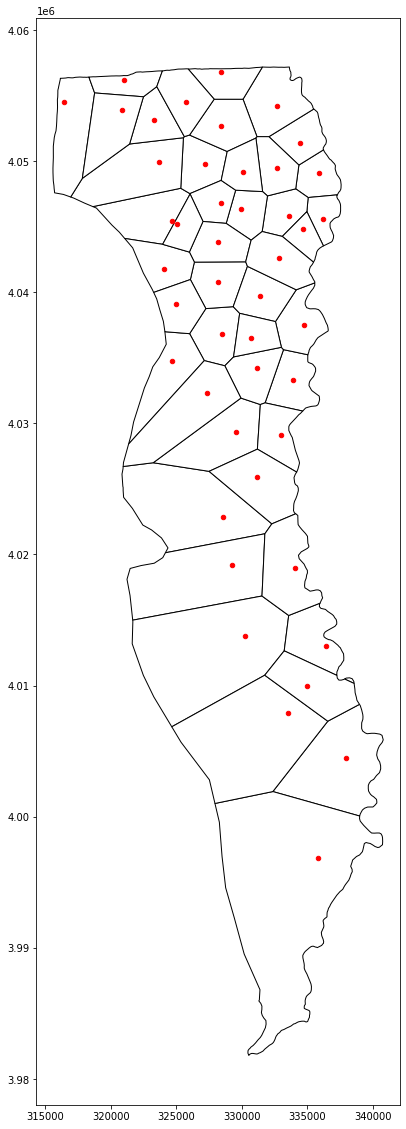

In [14]:
voro = gpd.read_file("output.geojson")

voro.set_crs("EPSG:32641", allow_override=True, inplace=True)
voro["AREA2"] = voro.geometry.area * 10000

ax = voro.plot(color='white', edgecolor='black', figsize=(20,20))
gdf.plot(ax=ax, marker='o', color='red', markersize=20)

In [15]:
voro

,INDEX,MAHDOUDE_NAME,MAHDOUDE_CODE,AQUIFER_NAME,LOCATION_NAME,X,Y,ZONEUTM,X_,Y_,MIN_YEAR,MAX_YEAR,LEVEL_MSL,LEVEL_SRTM,CHECK,AREA,geometry,AREA2
0,1,سرخس,6004,سرخس,اراضی حسن آباد جر -wb,324655,4045424,41,61.041198,36.538144,None,None,272,272,True,17.970496,"POLYGON ((326048.084 4047517.520, 326058.798 4...",1.797050e+11
1,2,سرخس,6004,سرخس,اول کچولی,328501,4036848,41,61.086043,36.461571,None,None,290,290,True,12.354495,"POLYGON ((327260.137 4038749.919, 329347.077 4...",1.235449e+11
2,3,سرخس,6004,سرخس,ایستگاه کنترل گاز,328548,4022853,41,61.089657,36.335480,None,None,347,347,True,49.403589,"POLYGON ((323248.745 4026996.044, 327508.172 4...",4.940359e+11
3,4,سرخس,6004,سرخس,بابا لقمان,335901,4049057,41,61.165995,36.572876,None,None,269,269,True,8.877529,"POLYGON ((335061.839 4047218.774, 334112.320 4...",8.877529e+10
4,5,سرخس,6004,سرخس,بعد از آصف- چاه شماره 5,333898,4033275,41,61.147012,36.430326,None,None,293,293,True,12.723486,"POLYGON ((333182.663 4035620.042, 335041.244 4...",1.272349e+11
5,6,سرخس,6004,سرخس,بعد از قوش سربزی عیسی مختاری,329550,4029350,41,61.099393,36.394198,None,None,303,303,True,23.505986,"POLYGON ((329935.059 4031926.356, 331417.014 4...",2.350599e+11
6,7,سرخس,6004,سرخس,بلوار امام رضا (ع),336223,4045565,41,61.170334,36.541466,None,None,274,274,True,6.383106,"POLYGON ((334964.004 4046144.658, 335061.839 4...",6.383106e+10
7,8,سرخس,6004,سرخس,بین تام مختار و کندکلی,327184,4049761,41,61.068462,36.577681,None,None,268,268,True,11.244847,"POLYGON ((325548.020 4051780.262, 325622.264 4...",1.124485e+11
8,9,سرخس,6004,سرخس,بین کچولی و قوش عظیم,331170,4034220,41,61.116388,36.438365,None,None,291,291,True,11.931257,"POLYGON ((329374.144 4035065.446, 333021.599 4...",1.193126e+11
9,10,سرخس,6004,سرخس,پشت پاسگاه سه گوش,334472,4051364,41,61.149535,36.593416,None,None,267,267,True,10.175446,"POLYGON ((334354.705 4049695.270, 332068.702 4...",1.017545e+11
